# Naïve model for financial tweet analysis

We will apply a naïve model to predict the sentiment score of set of tweets, To do so, we will use a dictionary `SentiWordNet`

We will improve our model by taking into account of potential emoji and negation and booster words in the tweets.

## Setup environement

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


### Import libs

In [3]:
# --- import utils libs ---
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
# --- import ML libs ---
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- import nlp libs ---
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus.reader import sentiwordnet as swn
from nltk.tag import map_tag


# HuggingFace
from datasets import load_dataset

# Download corpus
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Import dataset

The data we use comes from HuggingFace
The dataset holds 11,932 documents annotated with 3 labels:
* **Bearish = 0**
* **Bullish = 1**
* **Neutral = 2**

The data was collected using the Twitter API. The current dataset supports the multi-class classification task.

In [4]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

### Import test set

As in our case the Naive model is rules-based algorithm which use a dictionary to compute the sentitment score, we don't have train the model.
Hence, we will directly evalutate the model on the Test set

In [5]:
# Convert the dictionary to a DataFrame
tweets = pd.DataFrame(dataset['validation'])
tweets

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0
...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2
2384,Stocks making the biggest moves premarket: Fit...,2
2385,Stocks making the biggest moves premarket: Hom...,2
2386,Stocks making the biggest moves premarket: TD ...,2


In [6]:
tweets['text'][0]

'$ALLY - Ally Financial pulls outlook https://t.co/G9Zdi1boy5'

### Import Dictionary
The DicoSlang is a python dictionary that contains abbreviations and language specificities in tweets

In [ ]:
dico_slang = pd.read_csv("SlangLookupTable.txt", sep="\t", names = ["original", "new"], header=None, encoding = "latin1")
dico_slang

,original,new
0,121,one to one
1,a/s/l,"age, sex, location"
2,adn,any day now
3,afaik,as far as I know
4,afk,away from keyboard
...,...,...
85,wibni,wouldn't it be nice if
86,wtf,what the fuck
87,wtg,way to go
88,wtgp,want to go private


## Data preparation

In terms of preprocessing, we will operate as follow:
* Segment it into tokens thanks to `TweetTokenizer` thanks to `NLTK` library
* Remove urls
* Clean up characters inherent in the structure of a tweet (hashtags!)
* Correct abbreviations and language specificities in tweets using the DicoSlang dictionary (SlangLookupTable.txt file)

In [ ]:
def preprocessing_tweet(text_tweet, dico_slang):

    # tokenization du tweet avec TweetTokenizer (garde les émoticones, retire les @[username])
    tk = nltk.TweetTokenizer()
    text_tweet_tokenized = tk.tokenize(text_tweet)
    text_tweet_cleaned = list()

    original_list = dico_slang["original"].to_list()
    new_list = dico_slang["new"].to_list()

    # remove inherent tweet special characters like #hashtag
    for elm in text_tweet_tokenized:
        if elm.startswith('http'):
            pass

        elif elm.startswith('@'):
            pass

        elif elm.startswith("#"):
            elm = elm.split("#")[1]
            text_tweet_cleaned.append(elm)

        else:
            text_tweet_cleaned.append(elm)

        # Correction des abréviations et des spécificités langagières des tweets
        for i in range (len(original_list)):
            if original_list[i] == elm:
                new = new_list[i]
                list_word = word_tokenize(new)
                for word in list_word:
                    text_tweet_cleaned.append(word)

            if original_list[i] == elm:
                text_tweet_cleaned.remove(elm)

        # Remove empty string
        text_tweet_cleaned = [e for e in text_tweet_cleaned if e]

    return text_tweet_cleaned

### Tweet cleansing function test

In [ ]:
print("Original tweet test\n")
text_tweet = "121 @stellargirl #looser adn [link] [1 comment] @author #looser This is ! a text with! a URL https://www.java2blog.com/ to remove + :) ok =) ='( / #looser [link] [1 comment] @author #looser."
print(text_tweet)
print("\n-------------------\n")

print("Tweet test cleaned\n")
print(preprocessing_tweet(text_tweet, dico_slang))

Original tweet test

121 @stellargirl #looser adn [link] [1 comment] @author #looser This is ! a text with! a URL https://www.java2blog.com/ to remove + :) ok =) ='( / #looser [link] [1 comment] @author #looser.

-------------------

Tweet test cleaned

['one', 'to', 'one', 'looser', 'any', 'day', 'now', '[', 'link', ']', '[', '1', 'comment', ']', 'looser', 'This', 'is', '!', 'a', 'text', 'with', '!', 'a', 'URL', 'to', 'remove', '+', ':)', 'ok', '=)', "='(", '/', 'looser', '[', 'link', ']', '[', '1', 'comment', ']', 'looser', '.']


### Pre-processing the tweets in our dataset

In [ ]:
l_token = list()
for i in range(tweets.shape[0]):
    l_token.append(preprocessing_tweet(tweets.iloc[i,0], dico_slang))

tweets = tweets.join(pd.DataFrame({"tweet_cleaned":l_token}))
tweets

,text,label,tweet_cleaned
0,$ALLY - Ally Financial pulls outlook https://t...,0,"[$, ALLY, -, Ally, Financial, pulls, outlook]"
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"[$, DELL, $, HPE, -, Dell, ,, HPE, targets, tr..."
2,$PRTY - Moody's turns negative on Party City h...,0,"[$, PRTY, -, Moody's, turns, negative, on, Par..."
3,$SAN: Deutsche Bank cuts to Hold,0,"[$, SAN, :, Deutsche, Bank, cuts, to, Hold]"
4,$SITC: Compass Point cuts to Sell,0,"[$, SITC, :, Compass, Point, cuts, to, Sell]"
...,...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2,"[Stocks, making, the, biggest, moves, midday, ..."
2384,Stocks making the biggest moves premarket: Fit...,2,"[Stocks, making, the, biggest, moves, premarke..."
2385,Stocks making the biggest moves premarket: Hom...,2,"[Stocks, making, the, biggest, moves, premarke..."
2386,Stocks making the biggest moves premarket: TD ...,2,"[Stocks, making, the, biggest, moves, premarke..."


### Pos-Tagging
Knowing the grammatical category (or in this case the 'part of speech' or 'POS') of words will help us to carry out the sentiment analysis. We implement a function capable of determining the part of speech of each word in the tweet using the following command from the nltk library

In [ ]:
def pos_tagger(tweet_tokenized):
    tweet_pos_tag = nltk.pos_tag(tweet_tokenized)
    pos = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in tweet_pos_tag]
    return pos

tweet_bis = tweets["tweet_cleaned"][0]
pos_tagger(tweet_bis)

[('$', '.'),
 ('ALLY', 'NOUN'),
 ('-', '.'),
 ('Ally', 'NOUN'),
 ('Financial', 'NOUN'),
 ('pulls', 'NOUN'),
 ('outlook', 'NOUN')]

In [ ]:
l_tag = list()
for i in range(tweets.shape[0]):
    tagging = pos_tagger(tweets.iloc[i,2])
    l_tag.append(tagging)

tweets = tweets.join(pd.DataFrame({"tweet_pos_tag":l_tag}))
tweets

,text,label,tweet_cleaned,tweet_pos_tag
0,$ALLY - Ally Financial pulls outlook https://t...,0,"[$, ALLY, -, Ally, Financial, pulls, outlook]","[($, .), (ALLY, NOUN), (-, .), (Ally, NOUN), (..."
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"[$, DELL, $, HPE, -, Dell, ,, HPE, targets, tr...","[($, .), (DELL, NOUN), ($, .), (HPE, NOUN), (-..."
2,$PRTY - Moody's turns negative on Party City h...,0,"[$, PRTY, -, Moody's, turns, negative, on, Par...","[($, .), (PRTY, NOUN), (-, .), (Moody's, NOUN)..."
3,$SAN: Deutsche Bank cuts to Hold,0,"[$, SAN, :, Deutsche, Bank, cuts, to, Hold]","[($, .), (SAN, NOUN), (:, .), (Deutsche, NOUN)..."
4,$SITC: Compass Point cuts to Sell,0,"[$, SITC, :, Compass, Point, cuts, to, Sell]","[($, .), (SITC, NOUN), (:, .), (Compass, NOUN)..."
...,...,...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2,"[Stocks, making, the, biggest, moves, midday, ...","[(Stocks, NOUN), (making, VERB), (the, DET), (..."
2384,Stocks making the biggest moves premarket: Fit...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (..."
2385,Stocks making the biggest moves premarket: Hom...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (..."
2386,Stocks making the biggest moves premarket: TD ...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (..."


### Naive Model {SentiWordNet} (BASELINE MODEL)

Calculation for each tweet of the sum of the positive and negative scores of the tweet's synsets (1st synset),

Comparison of the sum of positive and negative scores for each tweet to decide which class to associate with the tweet.

The goal of this first approach is retrieve only words corresponding to adjectives, nouns (`NOUN`), adverbs (`ADV`) and verbs (`VERB`), and access the scores (positive and negative) of the first synset.

Note: The calculation of the positive and negative scores of the tweet synsets will automatically be based on the 1st synset of the word in question.

In [ ]:
wn.synsets('dog')

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01'),
 Synset('chase.v.01')]

In [ ]:
def compute_sentiment_score(post_tag_tweet):

    # ---- Initialisation ----
    accepted_tag = ["NOUN", "ADV", "VERB", "ADJ"]

    dicoSentiWordnetFile = 'SentiWordNet_3.0.0_20130122.txt'
    swn_dict = swn.SentiWordNetCorpusReader('', [dicoSentiWordnetFile])

    list_positive_score = list()
    list_negative_score = list()

    # Browse the tag list
    for tag in post_tag_tweet:
        # Search for the word in question in the dictionary (we take the first synset of the dictionary)
        senti_dict = list(swn_dict.senti_synsets(tag[0]))
        # We check that the word in question contains an accepted tag and we check that the word is contained in the dictionary
        if tag[1] in accepted_tag and len(senti_dict) > 0:
            # Search for the first synset that matches the word in question
            for idx, elm in enumerate(senti_dict):
                word = str(elm).split(".")[0].split("<")[1]
                # If the word matches the first synset, we calculate the scores
                if word == tag[0].lower():
                    list_positive_score.append(senti_dict[idx].pos_score())
                    list_negative_score.append(senti_dict[idx].neg_score())
                    break

    # Sum the scores of the different words in the tweet in question
    score_positive = sum(list_positive_score)
    score_negative = sum(list_negative_score)

    # Define the class by majority vote
    if score_positive > score_negative:
        classe = "bullish"
    if score_positive < score_negative:
        classe = "bearish"
    if score_positive == score_negative:
        classe = "neutral"

    return [score_positive, score_negative, classe]

In [ ]:
l_sentiment_scores = list()
for i in range(tweets.shape[0]):
    print(i)
    score = compute_sentiment_score(tweets.iloc[i,3])
    l_sentiment_scores.append(score)

tweets = tweets.join(pd.DataFrame({"sentiment_scores":l_sentiment_scores}))
tweets

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,text,label,tweet_cleaned,tweet_pos_tag,sentiment_scores
0,$ALLY - Ally Financial pulls outlook https://t...,0,"[$, ALLY, -, Ally, Financial, pulls, outlook]","[($, .), (ALLY, NOUN), (-, .), (Ally, NOUN), (...","[0.0, 0.0, neutral]"
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"[$, DELL, $, HPE, -, Dell, ,, HPE, targets, tr...","[($, .), (DELL, NOUN), ($, .), (HPE, NOUN), (-...","[0.375, 0.0, bullish]"
2,$PRTY - Moody's turns negative on Party City h...,0,"[$, PRTY, -, Moody's, turns, negative, on, Par...","[($, .), (PRTY, NOUN), (-, .), (Moody's, NOUN)...","[0.0, 0.25, bearish]"
3,$SAN: Deutsche Bank cuts to Hold,0,"[$, SAN, :, Deutsche, Bank, cuts, to, Hold]","[($, .), (SAN, NOUN), (:, .), (Deutsche, NOUN)...","[0.0, 0.25, bearish]"
4,$SITC: Compass Point cuts to Sell,0,"[$, SITC, :, Compass, Point, cuts, to, Sell]","[($, .), (SITC, NOUN), (:, .), (Compass, NOUN)...","[0.0, 0.0, neutral]"
...,...,...,...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2,"[Stocks, making, the, biggest, moves, midday, ...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]"
2384,Stocks making the biggest moves premarket: Fit...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]"
2385,Stocks making the biggest moves premarket: Hom...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]"
2386,Stocks making the biggest moves premarket: TD ...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]"


In [ ]:
df_sentiments = pd.DataFrame()

list_our_polarity_classe = list()
list_true_polarity_classe = list()

for i in range(tweets.shape[0]):

    classe = tweets["sentiment_scores"][i][2]
    list_our_polarity_classe.append(classe)

    if tweets["label"][i] == 1:
        list_true_polarity_classe.append("bullish")

    if tweets["label"][i] == 2:
        list_true_polarity_classe.append("neutral")

    if tweets["label"][i] == 0:
        list_true_polarity_classe.append("bearish")

df_sentiments["true_polarity"] = list_true_polarity_classe
df_sentiments["our_polarity"] = list_our_polarity_classe

df_sentiments

,true_polarity,our_polarity
0,bearish,neutral
1,bearish,bullish
2,bearish,bearish
3,bearish,bearish
4,bearish,neutral
...,...,...
2383,neutral,neutral
2384,neutral,neutral
2385,neutral,neutral
2386,neutral,neutral


#### Evaluate Naive Model {SentiWordNet}

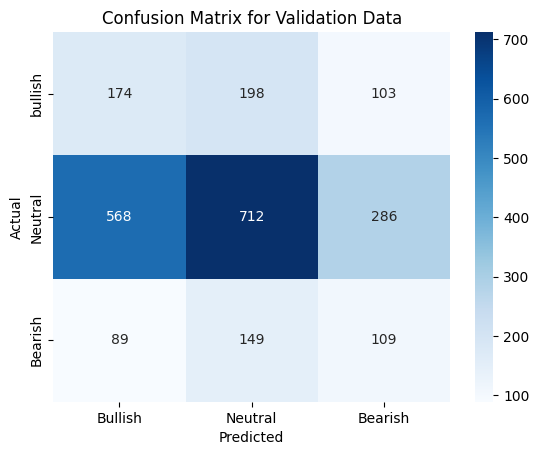

In [ ]:
conf_matrix = confusion_matrix(df_sentiments["true_polarity"], df_sentiments["our_polarity"], labels=['bullish', 'neutral', 'bearish'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bullish', 'Neutral', 'Bearish'], yticklabels=['bullish', 'Neutral', 'Bearish'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Data')
plt.show()

In [ ]:
# Compute classification report
y_true = df_sentiments["true_polarity"]
y_pred = df_sentiments["our_polarity"]

report = classification_report(y_true, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     bearish       0.22      0.31      0.26       347
     bullish       0.21      0.37      0.27       475
     neutral       0.67      0.45      0.54      1566

    accuracy                           0.42      2388
   macro avg       0.37      0.38      0.36      2388
weighted avg       0.51      0.42      0.45      2388



### Naive Model {SentiWordNet + Negation Words + Booster Words}

1st improvement Detection algorithm: managing negation and modifiers.

For each word, the algorithm must perform the following operations:

* multiply the negative and positive scores associated with the word by 2 if the preceding word is a modifier
* use only the word's negative score for the tweet's overall positive score and the word's positive score for the tweet's overall negative score if the preceding word is a negation.

Import the list containing negations `NegatingWordList.txt`

In [ ]:
neg_word_df = pd.read_csv("NegatingWordList.txt", header = None)
neg_word_df

,0
0,aren't
1,arent
2,can't
3,cannot
4,cant
5,don't
6,dont
7,isn't
8,isnt
9,never


Reading the list of booster words `BoosterWordList.txt`

In [ ]:
booster_word_df = pd.read_csv("BoosterWordList.txt", sep='\t', header = None)
booster_word_df

,0,1
0,absolutely,1
1,definitely,1
2,extremely,2
3,fuckin,2
4,fucking,2
5,hugely,2
6,incredibly,2
7,just,-1
8,overwhelmingly,2
9,so,0


Initially, the idea is to re-implement the function that calculates the sentiment score of a tweet based on the following 2 rules:


* multiply the negative and positive scores associated with the word by 2 if the preceding word is a modifier
* use only the negative score of the word for the overall positive score of the tweet and the positive score of the word for the overall negative score of the tweet if the preceding word is a negation.

*Example: I don't like cat don't is a negation and the score of the following word likesont {score_pos : 0.125, score_neg : 0.0} then the global positive score of the sentence is : 0.0 and the global negative score of the sentence becomes : 0.125*


We'll call this function `compute_sentiment_score_2`


Secondly, the idea is to take the rules we implemented previously for the first version of calculating the sentiment score (Detection algorithm: use of the Sentiwordnet dictionary) of a tweet and make them more complex by adding the rules from section (Detection algorithm: management of negation and modifiers).

Since we're keeping the rules we implemented previously, we're concentrating here only on words whose tag is ["NOUN", "ADV", "VERB", "ADJ"].

In [ ]:
def compute_sentiment_score_2(post_tag_tweet):
    accepted_tag = ["NOUN", "ADV", "VERB", "ADJ"]

    dicoSentiWordnetFile = 'SentiWordNet_3.0.0_20130122.txt'
    swn_dict = swn.SentiWordNetCorpusReader('', [dicoSentiWordnetFile])

    booster_word_df = pd.read_csv("BoosterWordList.txt", sep='\t', header = None)
    booster_word_list = booster_word_df[0].tolist()

    neg_word_df = pd.read_csv("NegatingWordList.txt", header = None)
    neg_word_list = neg_word_df[0].tolist()

    list_positive_score = list()
    list_negative_score = list()

    list_positive_score_global = list()
    list_negative_score_global = list()

    # Initialisation : Calcul des score de sentiment du 1er mot du tweet
    senti_dict = list(swn_dict.senti_synsets(post_tag_tweet[0][0]))
    if post_tag_tweet[0][1] in accepted_tag and len(senti_dict) > 0:
        for idx, elm in enumerate(senti_dict):
                word = str(elm).split(".")[0].split("<")[1]
                if word == post_tag_tweet[0][0].lower():
                    list_positive_score.append(senti_dict[idx].pos_score())
                    list_negative_score.append(senti_dict[idx].neg_score())
                    break

    for i in range (1, len(post_tag_tweet)):
        senti_dict = list(swn_dict.senti_synsets(post_tag_tweet[i][0]))
        if post_tag_tweet[i][1] in accepted_tag and len(senti_dict) > 0:
            for idx, elm in enumerate(senti_dict):
                word = str(elm).split(".")[0].split("<")[1]
                if word == post_tag_tweet[i][0].lower():

                    # On vérifie si le mot précédent du mot courant est une négation
                    if post_tag_tweet[i-1][0].lower() in neg_word_list:
                        list_positive_score_global.append(senti_dict[idx].pos_score())
                        list_negative_score_global.append(senti_dict[idx].neg_score())
                        break

                    # Si le mot précédent est un booster on multiplie les scores par 2
                    elif post_tag_tweet[i-1][0].lower() in booster_word_list:
                        list_positive_score.append(senti_dict[idx].pos_score() * 2)
                        list_negative_score.append(senti_dict[idx].neg_score() * 2)
                        break

                    else:
                        list_positive_score.append(senti_dict[idx].pos_score())
                        list_negative_score.append(senti_dict[idx].neg_score())
                        break



    if len(list_positive_score_global) > 0:
        score_positive = list_negative_score_global[0]
        score_negative = list_positive_score_global[0]
    else:
        score_positive = sum(list_positive_score)
        score_negative = sum(list_negative_score)


    # Define the class by majority vote
    if score_positive > score_negative:
        classe = "bullish"
    if score_positive < score_negative:
        classe = "bearish"
    if score_positive == score_negative:
        classe = "neutral"

    return [score_positive, score_negative, classe]

In [ ]:
l_sentiment_scores_2 = list()
for i in range(tweets.shape[0]):
    print(i)
    score = compute_sentiment_score_2(tweets.iloc[i,3])
    l_sentiment_scores_2.append(score)

tweets = tweets.join(pd.DataFrame({"sentiment_scores_2":l_sentiment_scores_2}))
tweets

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,text,label,tweet_cleaned,tweet_pos_tag,sentiment_scores,sentiment_scores_2
0,$ALLY - Ally Financial pulls outlook https://t...,0,"[$, ALLY, -, Ally, Financial, pulls, outlook]","[($, .), (ALLY, NOUN), (-, .), (Ally, NOUN), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]"
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"[$, DELL, $, HPE, -, Dell, ,, HPE, targets, tr...","[($, .), (DELL, NOUN), ($, .), (HPE, NOUN), (-...","[0.375, 0.0, bullish]","[0.375, 0.0, bullish]"
2,$PRTY - Moody's turns negative on Party City h...,0,"[$, PRTY, -, Moody's, turns, negative, on, Par...","[($, .), (PRTY, NOUN), (-, .), (Moody's, NOUN)...","[0.0, 0.25, bearish]","[0.0, 0.25, bearish]"
3,$SAN: Deutsche Bank cuts to Hold,0,"[$, SAN, :, Deutsche, Bank, cuts, to, Hold]","[($, .), (SAN, NOUN), (:, .), (Deutsche, NOUN)...","[0.0, 0.25, bearish]","[0.0, 0.25, bearish]"
4,$SITC: Compass Point cuts to Sell,0,"[$, SITC, :, Compass, Point, cuts, to, Sell]","[($, .), (SITC, NOUN), (:, .), (Compass, NOUN)...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]"
...,...,...,...,...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2,"[Stocks, making, the, biggest, moves, midday, ...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]"
2384,Stocks making the biggest moves premarket: Fit...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]"
2385,Stocks making the biggest moves premarket: Hom...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]"
2386,Stocks making the biggest moves premarket: TD ...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]"


### Evaluate Naive Model {SentiWordNet + Negation Words + Booster Word}

In [ ]:
df_sentiments_2 = pd.DataFrame()

list_our_polarity_classe = list()
list_true_polarity_classe = list()

for i in range(tweets.shape[0]):

    classe = tweets["sentiment_scores_2"][i][2]
    list_our_polarity_classe.append(classe)

    if tweets["label"][i] == 1:
        list_true_polarity_classe.append("bullish")

    if tweets["label"][i] == 2:
        list_true_polarity_classe.append("neutral")

    if tweets["label"][i] == 0:
        list_true_polarity_classe.append("bearish")

df_sentiments_2["true_polarity"] = list_true_polarity_classe
df_sentiments_2["our_polarity_2"] = list_our_polarity_classe

df_sentiments_2

,true_polarity,our_polarity_2
0,bearish,neutral
1,bearish,bullish
2,bearish,bearish
3,bearish,bearish
4,bearish,neutral
...,...,...
2383,neutral,neutral
2384,neutral,neutral
2385,neutral,neutral
2386,neutral,neutral


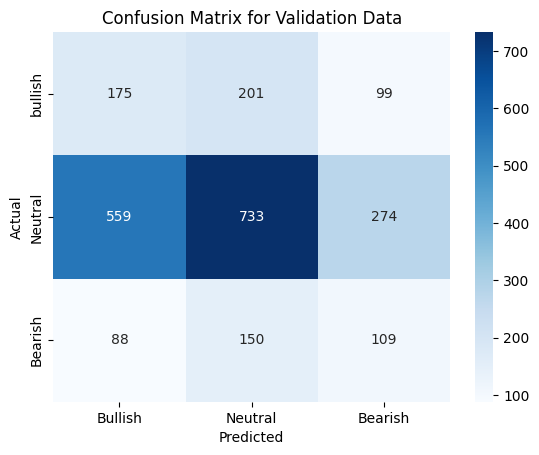

In [ ]:
conf_matrix = confusion_matrix(df_sentiments_2["true_polarity"], df_sentiments_2["our_polarity_2"], labels=['bullish', 'neutral', 'bearish'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bullish', 'Neutral', 'Bearish'], yticklabels=['bullish', 'Neutral', 'Bearish'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Data')
plt.show()

In [ ]:
# Compute classification report
y_true = df_sentiments_2["true_polarity"]
y_pred = df_sentiments_2["our_polarity_2"]

report = classification_report(y_true, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     bearish       0.23      0.31      0.26       347
     bullish       0.21      0.37      0.27       475
     neutral       0.68      0.47      0.55      1566

    accuracy                           0.43      2388
   macro avg       0.37      0.38      0.36      2388
weighted avg       0.52      0.43      0.45      2388



### Naive Model {Emoji}

2nd Improvement Detection algorithm: handling emoticons

Positive emoticons encountered increase the value of the tweet's positive score by 1, while negative emoticons increase the value of the tweet's negative score by 1.

The approach consists of simply implementing an algorithm that calculates sentiment scores using the rules mentioned previously. This means that we will rely solely on emoticons to calculate the sentiment score for each tweet.

Import the list containing emoticons `EmoticonLookupTable.txt`

In [2]:
import pandas as pd
df_emoticon = pd.read_csv("EmoticonLookupTable.txt", sep="\t", header=None, names=["emoticone", "score"])
df_emoticon

,emoticone,score
0,%-(,-1
1,%-),1
2,(-:,1
3,(:,1
4,(^ ^),1
...,...,...
110,xP,-1
111,|8C,-1
112,|8c,-1
113,|D,1


In [ ]:
def compute_sentiment_score_3(tweet_cleaned):
    df_emoticon = pd.read_csv("EmoticonLookupTable.txt", sep="\t", header=None, names=["emoticone", "score"])
    emoticones_list = df_emoticon['emoticone'].tolist()

    list_positive_score = list()
    list_negative_score = list()

    for elm in tweet_cleaned:
        if elm in emoticones_list:
            score_emoticone = df_emoticon.loc[df_emoticon['emoticone'] == elm]['score'].tolist()[0]
            if score_emoticone == 1:
                list_positive_score.append(1)
            if score_emoticone == -1:
                list_negative_score.append(1)

    score_positive = sum(list_positive_score)
    score_negative = sum(list_negative_score)

    # Define the class by majority vote
    if score_positive > score_negative:
        classe = "bullish"
    if score_positive < score_negative:
        classe = "bearish"
    if score_positive == score_negative:
        classe = "neutral"

    return [score_positive, score_negative, classe]

In [ ]:
l_sentiment_scores_3 = list()
for i in range(tweets.shape[0]):
    print(i)
    score = compute_sentiment_score_3(tweets.iloc[i,3])
    l_sentiment_scores_3.append(score)

tweets = tweets.join(pd.DataFrame({"sentiment_scores_3":l_sentiment_scores_3}))
tweets

In [ ]:
df_sentiments_3 = pd.DataFrame()

list_our_polarity_classe = list()
list_true_polarity_classe = list()

for i in range(tweets.shape[0]):

    classe = tweets["sentiment_scores_3"][i][2]
    list_our_polarity_classe.append(classe)

    if tweets["label"][i] == 1:
        list_true_polarity_classe.append("bullish")

    if tweets["label"][i] == 2:
        list_true_polarity_classe.append("neutral")

    if tweets["label"][i] == 0:
        list_true_polarity_classe.append("bearish")

df_sentiments_3["true_polarity"] = list_true_polarity_classe
df_sentiments_3["our_polarity_3"] = list_our_polarity_classe

df_sentiments_3

### Evaluate Naive Model {Emoji}



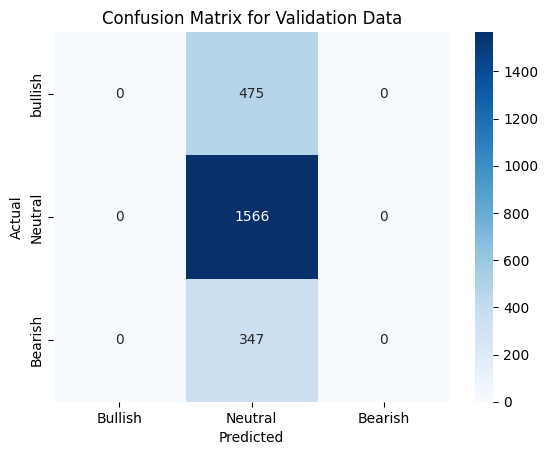

In [ ]:
conf_matrix = confusion_matrix(df_sentiments_3["true_polarity"], df_sentiments_3["our_polarity_3"], labels=['bullish', 'neutral', 'bearish'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bullish', 'Neutral', 'Bearish'], yticklabels=['bullish', 'Neutral', 'Bearish'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Data')
plt.show()

In [ ]:
# Compute classification report
y_true = df_sentiments_3["true_polarity"]
y_pred = df_sentiments_3["our_polarity_3"]

report = classification_report(y_true, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     bearish       0.00      0.00      0.00       347
     bullish       0.00      0.00      0.00       475
     neutral       0.66      1.00      0.79      1566

    accuracy                           0.66      2388
   macro avg       0.22      0.33      0.26      2388
weighted avg       0.43      0.66      0.52      2388



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Model {SentiWordNet + Negation Words + Booster Words + Emoji}

3rd Improvement : Handling booster and negative words and emoji

To improve and refine the calculation of sentiment scores for each tweet, the idea is to combine the rules in the following sections

In [ ]:
def compute_sentiment_score_4(post_tag_tweet):
    accepted_tag = ["NOUN", "ADV", "VERB", "ADJ"]

    dicoSentiWordnetFile = 'SentiWordNet_3.0.0_20130122.txt'
    swn_dict = swn.SentiWordNetCorpusReader('', [dicoSentiWordnetFile])

    booster_word_df = pd.read_csv("BoosterWordList.txt", sep='\t', header = None)
    booster_word_list = booster_word_df[0].tolist()

    neg_word_df = pd.read_csv("NegatingWordList.txt", header = None)
    neg_word_list = neg_word_df[0].tolist()

    df_emoticon = pd.read_csv("EmoticonLookupTable.txt", sep="\t", header=None, names=["emoticone", "score"])
    emoticones_list = df_emoticon['emoticone'].tolist()

    list_positive_score = list()
    list_negative_score = list()

    list_positive_score_global = list()
    list_negative_score_global = list()

    # Calcul des scores de sentiment du 1er mot du tweet
    senti_dict = list(swn_dict.senti_synsets(post_tag_tweet[0][0]))
    # On vérifie si le premier est une émoticone
    if post_tag_tweet[0][0] in emoticones_list:
        score_emoticone = df_emoticon.loc[df_emoticon['emoticone'] == post_tag_tweet[i][0]]['score'].tolist()[0]
        if score_emoticone == 1:
            list_positive_score.append(1)
        if score_emoticone == -1:
            list_negative_score.append(1)

    if post_tag_tweet[0][1] in accepted_tag and len(senti_dict) > 0:
        for idx, elm in enumerate(senti_dict):
                word = str(elm).split(".")[0].split("<")[1]
                if word == post_tag_tweet[0][0].lower():
                    list_positive_score.append(senti_dict[idx].pos_score())
                    list_negative_score.append(senti_dict[idx].neg_score())
                    break

    # On parcourt la liste des tags du reste des mot du tweet
    for i in range (1, len(post_tag_tweet)):
        senti_dict = list(swn_dict.senti_synsets(post_tag_tweet[i][0]))

        # On vérifie si le mot courant est une émoticone
        if post_tag_tweet[i][0] in emoticones_list:
            score_emoticone = df_emoticon.loc[df_emoticon['emoticone'] == post_tag_tweet[i][0]]['score'].tolist()[0]
            if score_emoticone == 1:
                list_positive_score.append(1)
                break
            if score_emoticone == -1:
                list_negative_score.append(1)
                break

        if post_tag_tweet[i][1] in accepted_tag and len(senti_dict) > 0:
            for idx, elm in enumerate(senti_dict):
                word = str(elm).split(".")[0].split("<")[1]
                if word == post_tag_tweet[i][0].lower():

                    # On vérifie si le mot précédent du mot courant est un négation
                    if post_tag_tweet[i-1][0].lower() in neg_word_list:
                        list_positive_score_global.append(senti_dict[idx].pos_score())
                        list_negative_score_global.append(senti_dict[idx].neg_score())
                        break

                    # Si le mot précédent est un booster on multiplie les scores par 2
                    elif post_tag_tweet[i-1][0].lower() in booster_word_list:
                        list_positive_score.append(senti_dict[idx].pos_score() * 2)
                        list_negative_score.append(senti_dict[idx].neg_score() * 2)
                        break

                    else:
                        list_positive_score.append(senti_dict[idx].pos_score())
                        list_negative_score.append(senti_dict[idx].neg_score())
                        break



    if len(list_positive_score_global) > 0:
        score_positive = list_negative_score_global[0]
        score_negative = list_positive_score_global[0]
    else:
        score_positive = sum(list_positive_score)
        score_negative = sum(list_negative_score)


    # Define the class by majority vote
    if score_positive > score_negative:
        classe = "bullish"
    if score_positive < score_negative:
        classe = "bearish"
    if score_positive == score_negative:
        classe = "neutral"

    return [score_positive, score_negative, classe]

### Evalute Naive Model {SentiWordNet + Negation Words + Booster Words + Emoji}

In [ ]:
l_sentiment_scores_4 = list()
for i in range(tweets.shape[0]):
    print(i)
    score = compute_sentiment_score_4(tweets.iloc[i,3])
    l_sentiment_scores_4.append(score)

tweets = tweets.join(pd.DataFrame({"sentiment_scores_4":l_sentiment_scores_4}))
tweets

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,text,label,tweet_cleaned,tweet_pos_tag,sentiment_scores,sentiment_scores_2,sentiment_scores_3,sentiment_scores_4
0,$ALLY - Ally Financial pulls outlook https://t...,0,"[$, ALLY, -, Ally, Financial, pulls, outlook]","[($, .), (ALLY, NOUN), (-, .), (Ally, NOUN), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]","[0, 0, neutral]","[0.0, 0.0, neutral]"
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"[$, DELL, $, HPE, -, Dell, ,, HPE, targets, tr...","[($, .), (DELL, NOUN), ($, .), (HPE, NOUN), (-...","[0.375, 0.0, bullish]","[0.375, 0.0, bullish]","[0, 0, neutral]","[0.375, 0.0, bullish]"
2,$PRTY - Moody's turns negative on Party City h...,0,"[$, PRTY, -, Moody's, turns, negative, on, Par...","[($, .), (PRTY, NOUN), (-, .), (Moody's, NOUN)...","[0.0, 0.25, bearish]","[0.0, 0.25, bearish]","[0, 0, neutral]","[0.0, 0.25, bearish]"
3,$SAN: Deutsche Bank cuts to Hold,0,"[$, SAN, :, Deutsche, Bank, cuts, to, Hold]","[($, .), (SAN, NOUN), (:, .), (Deutsche, NOUN)...","[0.0, 0.25, bearish]","[0.0, 0.25, bearish]","[0, 0, neutral]","[0.0, 0.25, bearish]"
4,$SITC: Compass Point cuts to Sell,0,"[$, SITC, :, Compass, Point, cuts, to, Sell]","[($, .), (SITC, NOUN), (:, .), (Compass, NOUN)...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]","[0, 0, neutral]","[0.0, 0.0, neutral]"
...,...,...,...,...,...,...,...,...
2383,Stocks making the biggest moves midday: TD Ame...,2,"[Stocks, making, the, biggest, moves, midday, ...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]","[0, 0, neutral]","[0.0, 0.0, neutral]"
2384,Stocks making the biggest moves premarket: Fit...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]","[0, 0, neutral]","[0.0, 0.0, neutral]"
2385,Stocks making the biggest moves premarket: Hom...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]","[0, 0, neutral]","[0.0, 0.0, neutral]"
2386,Stocks making the biggest moves premarket: TD ...,2,"[Stocks, making, the, biggest, moves, premarke...","[(Stocks, NOUN), (making, VERB), (the, DET), (...","[0.0, 0.0, neutral]","[0.0, 0.0, neutral]","[0, 0, neutral]","[0.0, 0.0, neutral]"


In [ ]:
df_sentiments_4 = pd.DataFrame()

list_our_polarity_classe = list()
list_true_polarity_classe = list()

for i in range(tweets.shape[0]):

    classe = tweets["sentiment_scores_4"][i][2]
    list_our_polarity_classe.append(classe)

    if tweets["label"][i] == 1:
        list_true_polarity_classe.append("bullish")

    if tweets["label"][i] == 2:
        list_true_polarity_classe.append("neutral")

    if tweets["label"][i] == 0:
        list_true_polarity_classe.append("bearish")

df_sentiments_4["true_polarity"] = list_true_polarity_classe
df_sentiments_4["our_polarity_4"] = list_our_polarity_classe

df_sentiments_4

,true_polarity,our_polarity_4
0,bearish,neutral
1,bearish,bullish
2,bearish,bearish
3,bearish,bearish
4,bearish,neutral
...,...,...
2383,neutral,neutral
2384,neutral,neutral
2385,neutral,neutral
2386,neutral,neutral


### Evaluate Naive Model {SentiWordNet + Negation Words + Booster Words + Emoji}

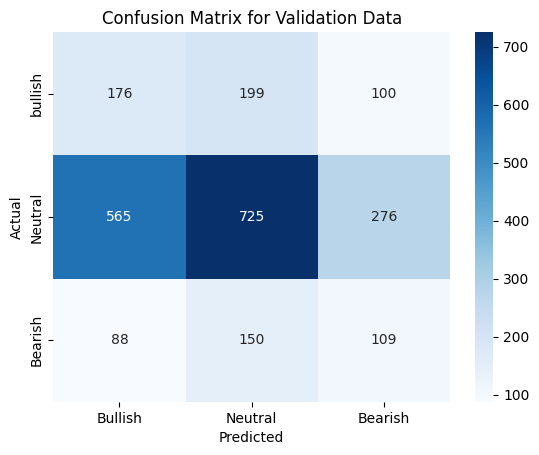

In [ ]:
conf_matrix = confusion_matrix(df_sentiments_4["true_polarity"], df_sentiments_4["our_polarity_4"], labels=['bullish', 'neutral', 'bearish'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bullish', 'Neutral', 'Bearish'], yticklabels=['bullish', 'Neutral', 'Bearish'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Data')
plt.show()

In [ ]:
# Compute classification report
y_true = df_sentiments_4["true_polarity"]
y_pred = df_sentiments_4["our_polarity_4"]

report = classification_report(y_true, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     bearish       0.22      0.31      0.26       347
     bullish       0.21      0.37      0.27       475
     neutral       0.68      0.46      0.55      1566

    accuracy                           0.42      2388
   macro avg       0.37      0.38      0.36      2388
weighted avg       0.52      0.42      0.45      2388

